In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

import sys
import numpy as np
import tensorflow.keras as keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Dense, Activation, LeakyReLU, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
import matplotlib.pyplot as plt
import pandas as pd
import os

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf

import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', None)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#https://keras.io/examples/generative/conditional_gan/#interpolating-between-classes-with-the-trained-generator

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
class ConditionalGAN(keras.Model):
    def __init__(self, noise_dim=50, 
                 data_shape=1,
                 num_classes=3, 
                 d_learning_rate=1e-5, 
                 g_learning_rate=1e-6, 
                 batch_size=64, 
                 start_epoch=0,
                 verbose = False, distribute = False):

        super(ConditionalGAN, self).__init__()
        self.noise_dim = noise_dim
        self.data_shape = data_shape # output shape of the generator and goes to discriminator
        self.num_classes = num_classes
        self.d_optimizer = tf.keras.optimizers.Adam(d_learning_rate)
        self.g_optimizer = tf.keras.optimizers.Adam(g_learning_rate)
        self.batch_size = batch_size
        self.start_epoch = start_epoch
        self.verbose = verbose
        self.distribute = distribute

        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

        # add number of class labels to the input channels for generator
        self.g_dim = self.noise_dim + self.num_classes

        # add the number of class labels to the input to the discriminator
        self.d_dim = self.data_shape + self.num_classes

        if (self.verbose):
            print("Generator input dim: ", self.g_dim)
            print("Dicrimination input dim: ", self.d_dim)


        # build generator and discriminator
        self.discriminator = self.build_discriminator()
        self.generator = self.build_generator()

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]
    
    def build_generator(self):
        "Build the generator model"
        inputs = Input(shape=(self.g_dim,))
        hidden = Dense(64)(inputs) # 128
        hidden = LeakyReLU(alpha=0.2)(hidden)
        hidden = BatchNormalization()(hidden)
        hidden = Dense(64)(hidden)
        hidden = LeakyReLU(alpha=0.2)(hidden)

        output = Dense(self.data_shape, activation="sigmoid")(hidden)
        #output = Dense(self.data_shape, activation="linear")(hidden)
        
        if self.distribute == False: 
          generator = Model(inputs=inputs, outputs=output, name="generator")

        elif self.distribute == 'G' or self.distribute.lower() == 'both':
          mirrored_strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy() #tf.distribute.MirroredStrategy()
          with mirrored_strategy.scope():

            generator = Model(inputs=inputs, outputs=output, name="generator")
            print('Number of devices: {}'.format(mirrored_strategy.num_replicas_in_sync))
            
        else:
            print('Unrecognized distribution call. Reverting to non distributed GAN.')
            generator = Model(inputs=inputs, outputs=output, name="generator")

        generator.summary()
        return generator


    def build_discriminator(self):
        "build the discriminator model"
        d_inputs = Input(shape=(self.d_dim,))
        h = Dense(64, input_shape=(self.g_dim,))(d_inputs) 
        h = LeakyReLU(alpha=0.2)(h)
        h = Dropout(0.1)(h)
        h = Dense(64)(h) #32
        h = LeakyReLU(alpha=0.2)(h)
        h = Dropout(0.1)(h)
        h = Dense(1, activation="sigmoid")(h)
        
        if self.distribute == False:
          discriminator = Model(d_inputs, h, name="discriminator")

        elif self.distribute == 'D' or self.distribute.lower() == 'both':
          mirrored_strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy() #tf.distribute.MirroredStrategy()
          with mirrored_strategy.scope():
            discriminator = Model(d_inputs, h, name="discriminator")
            print('Number of devices: {}'.format(mirrored_strategy.num_replicas_in_sync))
            
        else:
            print('Unrecognized distribution call. Reverting to non distributed GAN.')
            generator = Model(inputs=inputs, outputs=output, name="generator")      


        discriminator.summary()
        return discriminator

    def compile(self, loss_fn):
        super(ConditionalGAN, self).compile()
        self.loss_fn = loss_fn

    def train_step(self, data):
        # Unpack the data.
        real_ages, one_hot_labels = data
        real_ages = tf.cast(real_ages, tf.float32)
        #print("real_ages:", real_ages[0:2])

        # Add dummy dimensions to the labels so that they can be concatenated with
        # the images. This is for the discriminator.
        age_one_hot_labels = one_hot_labels[:, None]
        print("age_one_hot_labels1:", age_one_hot_labels[0:2])

        age_one_hot_labels = tf.repeat(age_one_hot_labels, repeats=[1])
        print("age_one_hot_labels2:", age_one_hot_labels[0:2])

        age_one_hot_labels = tf.reshape(age_one_hot_labels, (-1, self.num_classes))
        age_one_hot_labels = tf.cast(age_one_hot_labels, tf.float32)
        print("age_one_hot_labels3:", age_one_hot_labels[0:2])

        # Sample random points in the latent space and concatenate the labels.
        # This is for the generator.
        batch_size = tf.shape(real_ages)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.noise_dim))
        random_vector_labels = tf.concat([random_latent_vectors, one_hot_labels], axis=1)

        # Decode the noise (guided by labels) to fake ages.
        generated_ages = self.generator(random_vector_labels)
        generated_ages= tf.cast(generated_ages, tf.float32)

        # Combine them with real images. Note that we are concatenating the labels
        # with these images here. and tf.concat is on the last dimension (-1)
        fake_ages_and_labels = tf.concat([generated_ages, age_one_hot_labels], -1)
        real_ages_and_labels = tf.concat([real_ages, age_one_hot_labels], -1) 
        combined_ages = tf.concat([fake_ages_and_labels, real_ages_and_labels], axis=0)

        # Assemble labels discriminating real from fake ages. 1 == fake, 0 == real
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )

        # TODO: concerned that observations are ordered fake then real - do we want to concat, then shuffle, then separate?
        
        #labels = tf.random.shuffle(labels, seed = 24)

        # Train the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_ages)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space.t
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.noise_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Assemble labels that say "all real images".
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            fake_ages = self.generator(random_vector_labels)
            fake_ages_and_labels = tf.concat([fake_ages, age_one_hot_labels], -1)
            predictions = self.discriminator(fake_ages_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }


    '''def generate(self, n=1000, one_hot_label=[1., 0., 0., 0., 0., 0., 1., 0.]):
        """Generate n ages for a class"""
        print("Generating: ", n, " ages for unit type: ", one_hot_label)
        input_noise = tf.random.normal((n, self.noise_dim), 0, 1)
        random_vector_labels = tf.concat([input_noise, one_hot_label], axis=1)

        ages = self.generator(random_vector_labels)

        return ages.numpy()'''

In [6]:
#input_noise = tf.random.normal((1000, 50), 0, 1)
#random_vector_labels = tf.concat([input_noise, one_hot_label], axis=1)

In [7]:
#random_vector_labels = tf.concat([input_noise, [1., 0., 0.]], axis=1)

In [8]:
#random_latent_vectors#, one_hot_labels

In [9]:
ages_ethnicity_np = np.load("/content/drive/MyDrive/DS6050-main/eICU_gan/data/eICU_age_ethnicity.npy", allow_pickle=True)


In [10]:
ages_ethnicity_np

array([[(87,), ('Caucasian',)],
       [(87,), ('Caucasian',)],
       [(76,), ('Caucasian',)],
       ...,
       [(41,), ('African American',)],
       [(72,), ('Caucasian',)],
       [(50,), ('Caucasian',)]], dtype=object)

In [11]:
ethnicity_np = np.asarray(ages_ethnicity_np[:,1].flatten().tolist()).flatten()
print('ethnicity length: ', len(ethnicity_np))
#print(ethnicity_np[0:5])

ethnicity length:  2253


In [12]:
#df_ages_filtered

In [13]:
ages_ethnicity_np

array([[(87,), ('Caucasian',)],
       [(87,), ('Caucasian',)],
       [(76,), ('Caucasian',)],
       ...,
       [(41,), ('African American',)],
       [(72,), ('Caucasian',)],
       [(50,), ('Caucasian',)]], dtype=object)

In [14]:
np.load("/content/drive/MyDrive/DS6050-main/eICU_gan/data/eICU_age_ethnicity.npy", allow_pickle=True)

array([[(87,), ('Caucasian',)],
       [(87,), ('Caucasian',)],
       [(76,), ('Caucasian',)],
       ...,
       [(41,), ('African American',)],
       [(72,), ('Caucasian',)],
       [(50,), ('Caucasian',)]], dtype=object)

In [15]:
ages_ethnicity_np

array([[(87,), ('Caucasian',)],
       [(87,), ('Caucasian',)],
       [(76,), ('Caucasian',)],
       ...,
       [(41,), ('African American',)],
       [(72,), ('Caucasian',)],
       [(50,), ('Caucasian',)]], dtype=object)

In [16]:
df = pd.read_csv('/content/drive/MyDrive/DS6050-main/eICU_gan/data/data_3D_pasthistories.csv')

ages_ethnicity_np = df[['age', 'ethnicity', 'gender']].to_numpy()#np.load("/content/drive/MyDrive/DS6050-main/eICU_gan/data/eICU_age_ethnicity.npy", allow_pickle=True)
print('length: ', len(ages_ethnicity_np))
print(ages_ethnicity_np[0:5])

ages_np = np.asarray(ages_ethnicity_np[:,0].flatten().tolist()).flatten()
print('ages length: ', len(ages_np))
#print(ages_np[0:5])

ethnicity_np = np.asarray(ages_ethnicity_np[:,1].flatten().tolist()).flatten()
print('ethnicity length: ', len(ethnicity_np))
#print(ethnicity_np[0:5])

gender_np = np.asarray(ages_ethnicity_np[:,2].flatten().tolist()).flatten()
print('gender length: ', len(gender_np))
#print(ethnicity_np[0:5])


df_ages = pd.DataFrame(zip(ages_np, ethnicity_np, gender_np), columns=['age','ethnicity', 'gender'])
print(df_ages.shape)
print(df_ages.groupby('ethnicity').count())

# create data set without 90 or greater since that was a category flattened
print("==" * 30)
print("FILTERED:")
df_ages_filtered = df_ages.query("age < 90")
#df_ages_filtered['ethnicity_code'] = df_ages_filtered['ethnicity'].astype('category').cat.codes

for i in ['ethnicity', 'gender']:
  df_ages_filtered[i+'_code'] = df_ages_filtered[i].astype('category').cat.codes

print(df_ages_filtered.groupby('ethnicity').count())


mean_age_filtered = df_ages_filtered.age.mean()
std_age_filtered =  df_ages_filtered.age.std()
min_age_filtered =  df_ages_filtered.age.min()
max_age_filtered =  df_ages_filtered.age.max()

print("mean age: ", mean_age_filtered)
print("std age: ", np.round(std_age_filtered,3))
print("min age: ", min_age_filtered)
print("max age: ", max_age_filtered)

scaled_ages_filtered = [(x - min_age_filtered)/(max_age_filtered - min_age_filtered) for x in df_ages_filtered['age']]
all_ages = np.reshape(scaled_ages_filtered, (-1, 1))

#all_labels = keras.utils.to_categorical(df_ages_filtered['ethnicity_code'], 3)

all_labels = np.concatenate((keras.utils.to_categorical(df_ages_filtered['ethnicity_code'], df_ages_filtered['ethnicity_code'].max()+1), 
                             keras.utils.to_categorical(df_ages_filtered['gender_code'], 2)), axis = 1)

print(scaled_ages_filtered[0:5])
print(np.array(all_labels[0:5]))
print(f"Shape of ages: {all_ages.shape}")

print(f"Shape of labels: {all_labels.shape}")

# Create tf.data.Dataset.
dataset = tf.data.Dataset.from_tensor_slices((all_ages, all_labels))
dataset = dataset.shuffle(buffer_size=200).batch(64)
#list(dataset.as_numpy_iterator())
#for element in dataset:
#    print(element)


length:  2537
[[60.0 'Hispanic' 'Female']
 [63.0 'Caucasian' 'Male']
 [57.0 'Caucasian' 'Female']
 [87.0 'Caucasian' 'Male']
 [87.0 'Caucasian' 'Male']]
ages length:  2537
ethnicity length:  2537
gender length:  2537
(2537, 3)
                   age  gender
ethnicity                     
African American   275     275
Asian               27      27
Caucasian         1963    1963
Hispanic           151     151
Native American     24      24
Other/Unknown       97      97
FILTERED:
                   age  gender  ethnicity_code  gender_code
ethnicity                                                  
African American   272     272             272          272
Asian               23      23              23           23
Caucasian         1881    1881            1881         1881
Hispanic           149     149             149          149
Native American     24      24              24           24
Other/Unknown       93      93              93           93
mean age:  67.23300573300574
std ag

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [17]:
#oh_df = pd.read_csv("/content/drive/MyDrive/DS6050-main/eICU_gan/data/data_3D_pasthistories.csv")

In [18]:
#oh_df.columns

In [19]:
#oh_df.head()

<function matplotlib.pyplot.show>

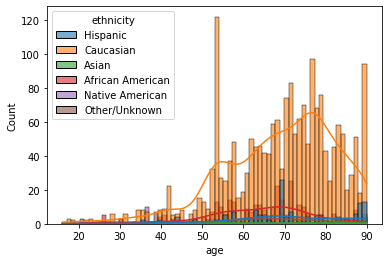

In [20]:
sns.histplot(data=df_ages, x='age', hue='ethnicity', bins=70, color='orange', kde=True, alpha=0.6)
plt.show

In [21]:
# one hot encode the ethnicity
encoder = OneHotEncoder(handle_unknown='ignore', categories = 'auto')
encoder_df = pd.DataFrame(encoder.fit_transform(df_ages[['ethnicity', 'gender']]).toarray(), columns = encoder.get_feature_names(['ethnicity', 'gender']))

#merge one-hot encoded columns back with original DataFrame
final_df = df_ages.join(encoder_df)
#final_df.columns = encoder.get_feature_names(['ethnicity', 'gender'])
final_df.tail()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,age,ethnicity,gender,ethnicity_African American,ethnicity_Asian,ethnicity_Caucasian,ethnicity_Hispanic,ethnicity_Native American,ethnicity_Other/Unknown,gender_Female,gender_Male
2532,41.0,African American,Male,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2533,41.0,African American,Male,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2534,50.0,Caucasian,Male,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2535,50.0,Caucasian,Male,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2536,50.0,Caucasian,Male,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [22]:
#pd.DataFrame(encoder.fit_transform(oh_df[['ethnicity', 'gender']]).toarray(), columns = encoder.get_feature_names(['ethnicity', 'gender'])).head()

In [23]:
all_labels[:1].shape[1]

8

In [24]:
#encoder.get_feature_names(['gender', 'ethnicity'])

In [25]:
pd.DataFrame(all_labels).sum()

0     272.0
1      23.0
2    1881.0
3     149.0
4      24.0
5      93.0
6     993.0
7    1449.0
dtype: float32

In [26]:
all_ages

array([[0.60273973],
       [0.64383562],
       [0.56164384],
       ...,
       [0.46575342],
       [0.46575342],
       [0.46575342]])

## Plan
1. Create the kde for each unit type (class)
2. Sample from the kde on each training round per class
    1. sample the same number of points as we have per class (e.g. 65 samples from the CSICU class)
3. instead of training valid and fake spearately - intermingle and train together

In [27]:
cgan = ConditionalGAN(noise_dim=50,
                 data_shape=1,
                 num_classes=all_labels[:1].shape[1], 
                 d_learning_rate=1e-6, 
                 g_learning_rate=1e-6, 
                 batch_size=32, 
                 start_epoch=0,
                 verbose = True)

Generator input dim:  58
Dicrimination input dim:  9
Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 9)]               0         
                                                                 
 dense (Dense)               (None, 64)                640       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64)                0         
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64)                0         
                                                                 


In [28]:
cgan.compile(loss_fn=keras.losses.BinaryCrossentropy(from_logits=True))

In [29]:
dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 8), dtype=tf.float32, name=None))>

In [30]:
#x, y = dataset

In [31]:
cgan.fit(dataset, epochs=10, verbose=True)

Epoch 1/10
age_one_hot_labels1: Tensor("strided_slice_1:0", shape=(None, 1, 8), dtype=float32)
age_one_hot_labels2: Tensor("strided_slice_2:0", shape=(None,), dtype=float32)
age_one_hot_labels3: Tensor("strided_slice_3:0", shape=(None, 8), dtype=float32)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


age_one_hot_labels1: Tensor("strided_slice_1:0", shape=(None, 1, 8), dtype=float32)
age_one_hot_labels2: Tensor("strided_slice_2:0", shape=(None,), dtype=float32)
age_one_hot_labels3: Tensor("strided_slice_3:0", shape=(None, 8), dtype=float32)
39/39 [==============================] - 3s 8ms/step - g_loss: 0.6164 - d_loss: 0.6969
Epoch 2/10
39/39 [==============================] - 0s 10ms/step - g_loss: 0.6169 - d_loss: 0.6968
Epoch 3/10
39/39 [==============================] - 0s 12ms/step - g_loss: 0.6174 - d_loss: 0.6967
Epoch 4/10
39/39 [==============================] - 0s 8ms/step - g_loss: 0.6181 - d_loss: 0.6967
Epoch 5/10
39/39 [==============================] - 0s 9ms/step - g_loss: 0.6187 - d_loss: 0.6966
Epoch 6/10
39/39 [==============================] - 0s 7ms/step - g_loss: 0.6192 - d_loss: 0.6963
Epoch 7/10
39/39 [==============================] - 0s 7ms/step - g_loss: 0.6197 - d_loss: 0.6962
Epoch 8/10
39/39 [==============================] - 0s 8ms/step - g_loss: 0.620

In [32]:
df_ages.groupby(['ethnicity', 'gender']).count().iloc[0].name

('African American', 'Female')

In [33]:
final_df.columns

Index(['age', 'ethnicity', 'gender', 'ethnicity_African American',
       'ethnicity_Asian', 'ethnicity_Caucasian', 'ethnicity_Hispanic',
       'ethnicity_Native American', 'ethnicity_Other/Unknown', 'gender_Female',
       'gender_Male'],
      dtype='object')

In [35]:
def generate_table(df, features = ['ethnicity', 'gender']):
  i = 0
  for j in range(df[features[0]].unique().shape[0]):
    a = np.zeros(df[features[0]].unique().shape[0])
    a[j] = 1
    for k in range(df[features[1]].unique().shape[0]):
      b = np.zeros(df[features[1]].unique().shape[0])
      b[k] = 1
      """Generate n ages for a class"""
      print("Generating: ", df.groupby(features).count().iloc[i], " ages for unit type: ", 
            df.groupby(features).count().iloc[i].name)

      age_one_hot_labels = tf.repeat([np.concatenate((a, b))],df.groupby(features).count().iloc[i], axis=0)

      input_noise = tf.random.normal((df.groupby(features).count().iloc[i][0], cgan.noise_dim), 0, 1)
      random_vector_labels = tf.concat([input_noise, tf.cast(age_one_hot_labels, dtype=tf.float32)], axis=1)

      ages = cgan.generator(random_vector_labels)

      inv_gen_ages = [(val * (max_age_filtered-min_age_filtered)) + min_age_filtered for val in ages.numpy().flatten()]

      print("Generated Ages:")
      print("min: ", np.min(inv_gen_ages))
      print("mean: ", np.mean(inv_gen_ages))
      print("max: ", np.max(inv_gen_ages))
      print("stdv: ", np.std(inv_gen_ages))

      eth = df.groupby(features).count().iloc[i].name[0]
      gen = df.groupby(features).count().iloc[i].name[1]

      df_ages_class = final_df.query("ethnicity == '" + eth + "'& gender == '" + gen+"'")

      print("True Ages:")
      print("min: ", np.min(df_ages_class.age))
      print("mean: ", np.mean(df_ages_class.age))
      print("max: ", np.max(df_ages_class.age))
      print("stdv: ", np.std(df_ages_class.age))

      df_temp = pd.DataFrame(columns = ['age'] + features)

      df_temp['age'] = inv_gen_ages
      df_temp['ethnicity'] = eth
      df_temp['gender'] = gen
      #print(df_temp)

      if i == 0:
        df_age_eth = pd.DataFrame(columns = ['age'] + features)

      df_age_eth = df_age_eth.append(df_temp)
      i+=1
      print(' ')

  return df_age_eth
  '''
      sns.histplot(inv_gen_ages, bins=70, label='GAN', kde=True,)
      sns.histplot(df_ages_class.age, bins=70, color='orange', label='Truth', alpha=0.3, kde=True,)
      plt.title(eth + ' Ages')
      plt.legend()
      plt.show
  '''

In [36]:
df_age_eth = generate_table(df_ages)

Generating:  age    104
Name: (African American, Female), dtype: int64  ages for unit type:  ('African American', 'Female')
Generated Ages:
min:  38.04674956202507
mean:  56.85342168034269
max:  73.34357476234436
stdv:  7.152627510625654
True Ages:
min:  19.0
mean:  60.88461538461539
max:  90.0
stdv:  15.83284541965974
 
Generating:  age    171
Name: (African American, Male), dtype: int64  ages for unit type:  ('African American', 'Male')
Generated Ages:
min:  36.042571395635605
mean:  55.2702133876887
max:  72.6297355890274
stdv:  7.12413898370285
True Ages:
min:  33.0
mean:  64.70175438596492
max:  87.0
stdv:  11.075970902140083
 
Generating:  age    15
Name: (Asian, Female), dtype: int64  ages for unit type:  ('Asian', 'Female')
Generated Ages:
min:  50.49576309323311
mean:  59.51114151080449
max:  67.26851439476013
stdv:  5.575980089973162
True Ages:
min:  51.0
mean:  67.6
max:  90.0
stdv:  15.877867195145154
 
Generating:  age    12
Name: (Asian, Male), dtype: int64  ages for unit

In [37]:
df_age_eth.groupby(['ethnicity', 'gender']).describe()

age                                             \
                          count       mean       std        min        25%   
ethnicity        gender                                                      
African American Female   104.0  56.853422  7.187265  38.046750  51.495357   
                 Male     171.0  55.270213  7.145062  36.042571  50.438701   
Asian            Female    15.0  59.511142  5.771688  50.495763  55.122745   
                 Male      12.0  54.711328  5.657597  46.345449  51.285672   
Caucasian        Female   877.0  56.883458  7.081330  37.131520  51.980330   
                 Male    1086.0  54.488214  7.222553  30.767179  49.585782   
Hispanic         Female    32.0  57.711962  6.314194  44.671082  52.232894   
                 Male     119.0  55.377369  7.997992  35.856780  49.513452   
Native American  Female     3.0  59.787952  1.828063  57.761776  59.025101   
                 Male      21.0  59.163032  5.940237  51.128316  53.985823   
Other/Unknown    Female    17.0  57.577316  9.220218  40.988161  50.832687   
                 Male      80.0  55.780818  7.105373  39.156053  51.502764   

                                                          
                               50%        75%        max  
ethnicity        gender                                   
African American Female  57.403120  62.071719  73.343575  
                 Male    55.820659  59.762221  72.629736  
Asian            Female  59.890388  63.868606  67.268514  
                 Male    54.224054  56.266200  67.474123  
Caucasian        Female  56.776191  61.844062  75.520580  
                 Male    54.491928  59.437667  74.421100  
Hispanic         Female  57.722387  62.049286  71.040365  
                 Male    56.328724  60.889973  73.878051  
Native American  Female  60.288426  60.801040  61.313654  
                 Male    58.665159  63.414236  74.790764  
Other/Unknown    Female  56.730691  66.625007  69.931916  
                 Male    55.577158  60.122336  71.183256

**Evaluation**

In [38]:
df_age_eth['data'] = 'GAN'

In [39]:
!pip install table_evaluator

In [40]:
#https://pypi.org/project/table-evaluator/
from table_evaluator import load_data, TableEvaluator


In [41]:
final_df.head()

,age,ethnicity,gender,ethnicity_African American,ethnicity_Asian,ethnicity_Caucasian,ethnicity_Hispanic,ethnicity_Native American,ethnicity_Other/Unknown,gender_Female,gender_Male
0,60.0,Hispanic,Female,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,63.0,Caucasian,Male,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,57.0,Caucasian,Female,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,87.0,Caucasian,Male,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,87.0,Caucasian,Male,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [42]:
final_df['data'] = 'Truth'

In [43]:
df_true = final_df[['age', 'ethnicity', 'gender']]

In [44]:
df_all = final_df[['age', 'ethnicity', 'gender', 'data']].append(df_age_eth).reset_index(level = 0).drop('index', axis = 1)

In [45]:
table_evaluator = TableEvaluator(df_all[df_all['data'] == 'Truth'][['age', 'ethnicity', 'gender']], df_all[df_all['data'] == 'GAN'][['age', 'ethnicity', 'gender']], cat_cols=['ethnicity', 'gender'])


In [46]:
table_evaluator.evaluate(target_col='ethnicity')


Classifier F1-scores and their Jaccard similarities::
                             f1_real  f1_fake  jaccard_similarity
index                                                            
DecisionTreeClassifier_fake   0.7559   0.6240              0.6025
DecisionTreeClassifier_real   0.7795   0.5098              0.4250
LogisticRegression_fake       0.7756   0.7756              1.0000
LogisticRegression_real       0.7638   0.7638              1.0000
MLPClassifier_fake            0.7756   0.7756              1.0000
MLPClassifier_real            0.7638   0.7638              1.0000
RandomForestClassifier_fake   0.7382   0.6240              0.5703
RandomForestClassifier_real   0.7756   0.5236              0.4494

Privacy results:
                                            result
Duplicate rows between sets (real/fake)  (2463, 0)
nearest neighbor mean                       0.0253
nearest neighbor std                        0.1212

Miscellaneous results:
                                  Resul

In [47]:
df_true.append(df_age_eth[['age', 'ethnicity', 'gender']]).to_csv('age_eth_gen_output.csv')

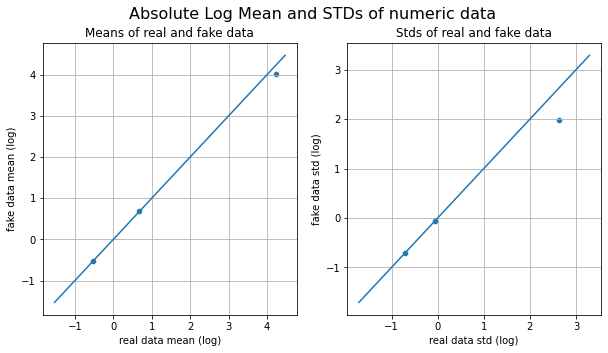

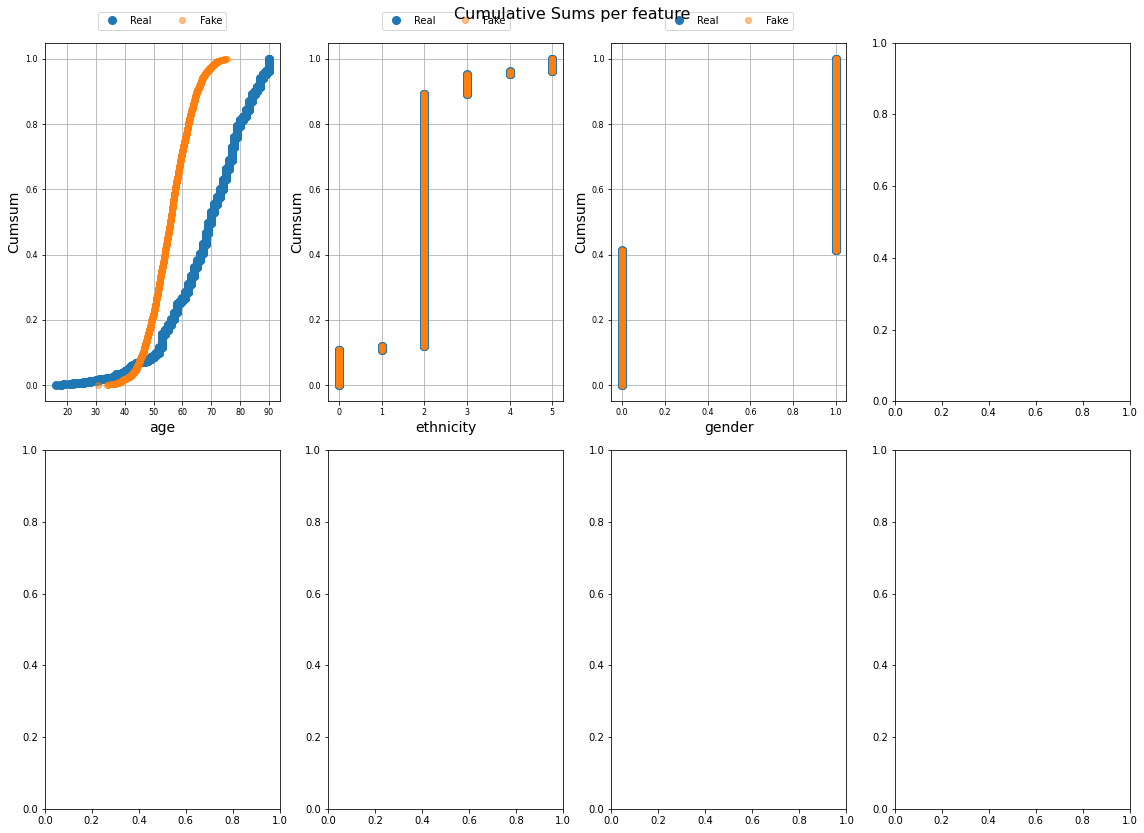

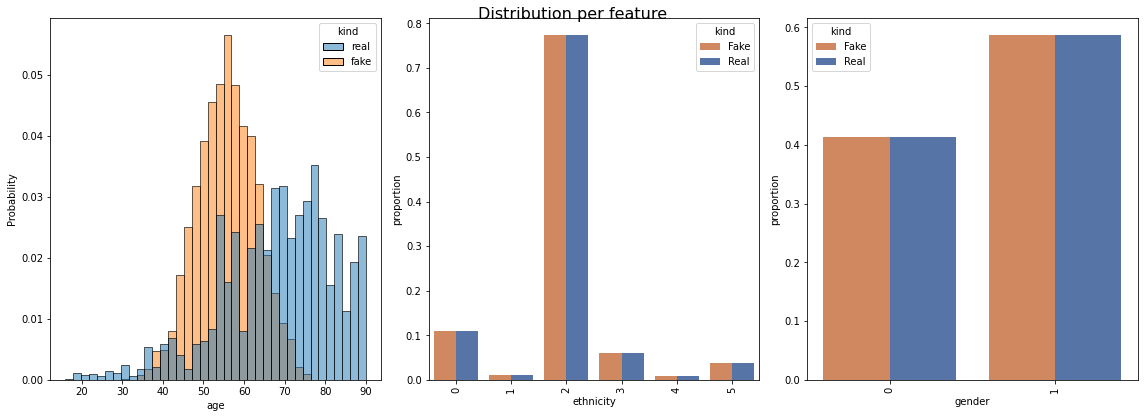

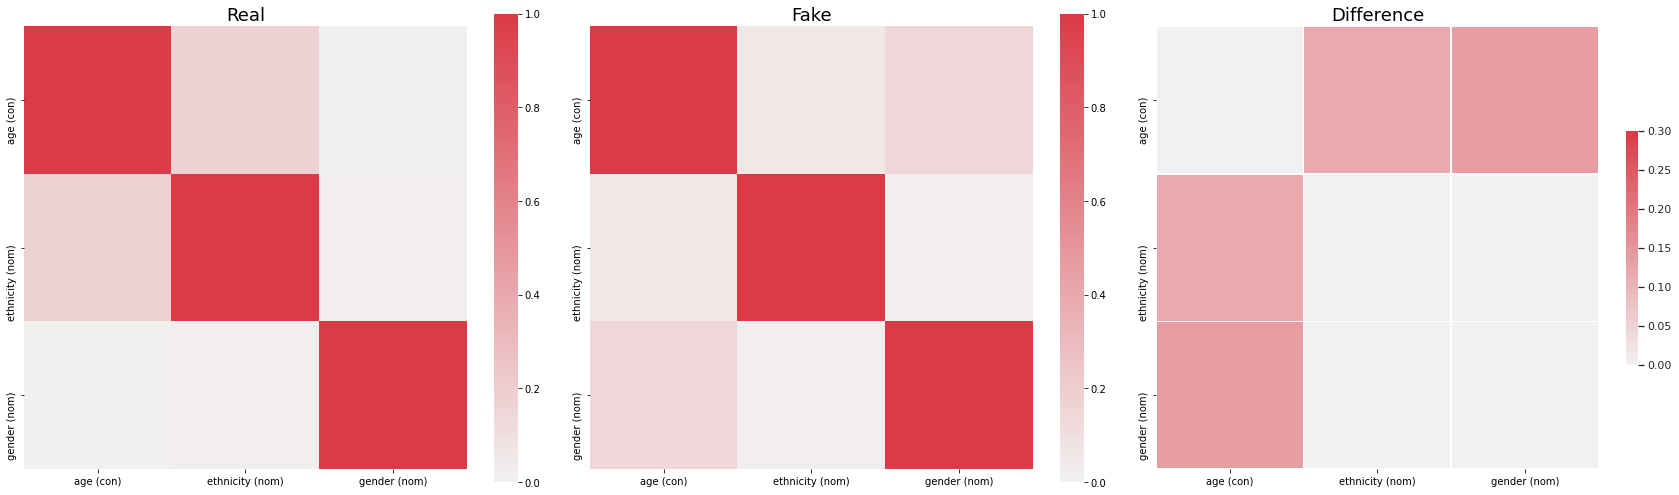

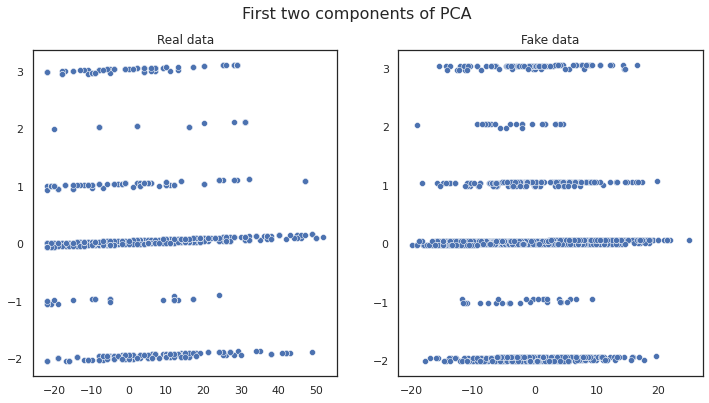

In [48]:
table_evaluator.visual_evaluation()

**Distribute**
https://www.tensorflow.org/tutorials/distribute/custom_training

In [49]:
mirrored_strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(mirrored_strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Number of devices: 1


In [50]:
# Create a checkpoint directory to store the checkpoints.
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

In [51]:
#with mirrored_strategy.scope():
dist_gan = ConditionalGAN(noise_dim=50,
                 data_shape=1,
                 num_classes=all_labels[:1].shape[1], 
                 d_learning_rate=1e-6, 
                 g_learning_rate=1e-6, 
                 batch_size=32, 
                 start_epoch=0,
                 verbose = True, distribute = 'D') # added the distributed flag in the CGAN class

  #loss_obj = tf.keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
  #loss = tf.reduce_sum(loss_obj(labels, predictions)) * (1. / global_batch_size)

dist_gan.compile(loss_fn=keras.losses.BinaryCrossentropy(from_logits=True))

Generator input dim:  58
Dicrimination input dim:  9
Instructions for updating:
use distribute.MultiWorkerMirroredStrategy instead
INFO:tensorflow:Single-worker MultiWorkerMirroredStrategy with local_devices = ('/device:CPU:0',), communication = CommunicationImplementation.AUTO
Number of devices: 1
Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 9)]               0         
                                                                 
 dense_6 (Dense)             (None, 64)                640       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 64)                0         
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense) 

In [52]:
dist_gan.fit(dataset, epochs=10, verbose=True)

Epoch 1/10
age_one_hot_labels1: Tensor("strided_slice_1:0", shape=(None, 1, 8), dtype=float32)
age_one_hot_labels2: Tensor("strided_slice_2:0", shape=(None,), dtype=float32)
age_one_hot_labels3: Tensor("strided_slice_3:0", shape=(None, 8), dtype=float32)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


age_one_hot_labels1: Tensor("strided_slice_1:0", shape=(None, 1, 8), dtype=float32)
age_one_hot_labels2: Tensor("strided_slice_2:0", shape=(None,), dtype=float32)
age_one_hot_labels3: Tensor("strided_slice_3:0", shape=(None, 8), dtype=float32)
39/39 [==============================] - 3s 5ms/step - g_loss: 0.7578 - d_loss: 0.7005
Epoch 2/10
39/39 [==============================] - 0s 7ms/step - g_loss: 0.7572 - d_loss: 0.7003
Epoch 3/10
39/39 [==============================] - 0s 7ms/step - g_loss: 0.7568 - d_loss: 0.7004
Epoch 4/10
39/39 [==============================] - 0s 10ms/step - g_loss: 0.7568 - d_loss: 0.7001
Epoch 5/10
39/39 [==============================] - 0s 8ms/step - g_loss: 0.7561 - d_loss: 0.7001
Epoch 6/10
39/39 [==============================] - 0s 8ms/step - g_loss: 0.7557 - d_loss: 0.6998
Epoch 7/10
39/39 [==============================] - 0s 7ms/step - g_loss: 0.7552 - d_loss: 0.6998
Epoch 8/10
39/39 [==============================] - 0s 8ms/step - g_loss: 0.7546

In [53]:
dist_age_eth = generate_table(df_ages)

Generating:  age    104
Name: (African American, Female), dtype: int64  ages for unit type:  ('African American', 'Female')
Generated Ages:
min:  38.034816563129425
mean:  56.12315572282443
max:  72.545419216156
stdv:  6.311142233425098
True Ages:
min:  19.0
mean:  60.88461538461539
max:  90.0
stdv:  15.83284541965974
 
Generating:  age    171
Name: (African American, Male), dtype: int64  ages for unit type:  ('African American', 'Male')
Generated Ages:
min:  38.5796183347702
mean:  54.27196181831304
max:  69.02104878425598
stdv:  7.627838459749762
True Ages:
min:  33.0
mean:  64.70175438596492
max:  87.0
stdv:  11.075970902140083
 
Generating:  age    15
Name: (Asian, Female), dtype: int64  ages for unit type:  ('Asian', 'Female')
Generated Ages:
min:  44.783563792705536
mean:  59.777543771266934
max:  74.36236786842346
stdv:  7.911177691606658
True Ages:
min:  51.0
mean:  67.6
max:  90.0
stdv:  15.877867195145154
 
Generating:  age    12
Name: (Asian, Male), dtype: int64  ages for un

In [54]:
dist_age_eth.head()

,age,ethnicity,gender
0,52.3226,African American,Female
1,59.0010,African American,Female
2,43.1507,African American,Female
3,49.0686,African American,Female
4,55.6241,African American,Female


In [55]:
df_ages.groupby(['ethnicity', 'gender']).describe()

age                                          \
                             count    mean     std     min     25%     50%   
ethnicity        gender                                                      
African American Female   104.0000 60.8846 15.9095 19.0000 54.0000 63.0000   
                 Male     171.0000 64.7018 11.1085 33.0000 57.0000 67.0000   
Asian            Female    15.0000 67.6000 16.4352 51.0000 56.0000 56.0000   
                 Male      12.0000 75.1667 13.5970 44.0000 73.0000 77.0000   
Caucasian        Female   877.0000 69.2851 13.6667 16.0000 61.0000 71.0000   
                 Male   1,086.0000 68.6805 13.6328 19.0000 59.0000 70.0000   
Hispanic         Female    32.0000 63.4062 19.4553 21.0000 56.0000 59.0000   
                 Male     119.0000 71.3697 13.2370 36.0000 64.0000 69.0000   
Native American  Female     3.0000 52.0000  0.0000 52.0000 52.0000 52.0000   
                 Male      21.0000 53.0476 18.3997 37.0000 37.0000 40.0000   
Other/Unknown    Female    17.0000 70.5294 10.0007 55.0000 62.0000 73.0000   
                 Male      80.0000 63.5000 14.3976 39.0000 57.2500 65.0000   

                                         
                            75%     max  
ethnicity        gender                  
African American Female 70.5000 90.0000  
                 Male   72.0000 87.0000  
Asian            Female 88.0000 90.0000  
                 Male   84.2500 90.0000  
Caucasian        Female 79.0000 90.0000  
                 Male   78.0000 90.0000  
Hispanic         Female 83.0000 90.0000  
                 Male   81.5000 90.0000  
Native American  Female 52.0000 52.0000  
                 Male   66.0000 88.0000  
Other/Unknown    Female 78.0000 86.0000  
                 Male   73.2500 90.0000

**Evaluation**

In [56]:
dist_age_eth['data'] = 'GAN'

In [57]:
!pip install table_evaluator

In [58]:
#https://pypi.org/project/table-evaluator/
from table_evaluator import load_data, TableEvaluator


In [59]:
final_df.head()

,age,ethnicity,gender,ethnicity_African American,ethnicity_Asian,ethnicity_Caucasian,ethnicity_Hispanic,ethnicity_Native American,ethnicity_Other/Unknown,gender_Female,gender_Male,data
0,60.0000,Hispanic,Female,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,Truth
1,63.0000,Caucasian,Male,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,Truth
2,57.0000,Caucasian,Female,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,Truth
3,87.0000,Caucasian,Male,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,Truth
4,87.0000,Caucasian,Male,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,Truth


In [60]:
final_df['data'] = 'Truth'

In [61]:
df_true = final_df[['age', 'ethnicity', 'gender']].reset_index().drop('index', axis = True)

In [62]:
dist_age_eth.reset_index(level = 0, inplace = True)

In [63]:
df_all = final_df[['age', 'ethnicity', 'gender', 'data']].append(dist_age_eth.drop('index', axis = 1)).reset_index(level = 0).drop('index', axis = 1)

In [64]:
table_evaluator = TableEvaluator(df_all[df_all['data'] == 'Truth'][['age', 'ethnicity', 'gender']], 
                                 df_all[df_all['data'] == 'GAN'][['age', 'ethnicity', 'gender']], cat_cols=['ethnicity', 'gender'])


In [65]:
table_evaluator.evaluate(target_col='ethnicity')


Classifier F1-scores and their Jaccard similarities::
                             f1_real  f1_fake  jaccard_similarity
index                                                            
DecisionTreeClassifier_fake   0.7402   0.6417              0.6230
DecisionTreeClassifier_real   0.7854   0.5492              0.4556
LogisticRegression_fake       0.7992   0.7992              1.0000
LogisticRegression_real       0.7933   0.7933              1.0000
MLPClassifier_fake            0.7992   0.7992              1.0000
MLPClassifier_real            0.7933   0.7933              1.0000
RandomForestClassifier_fake   0.7283   0.6575              0.6256
RandomForestClassifier_real   0.7854   0.5531              0.4619

Privacy results:
                                            result
Duplicate rows between sets (real/fake)  (2463, 4)
nearest neighbor mean                       0.0370
nearest neighbor std                        0.1605

Miscellaneous results:
                                  Resul

In [66]:
df_true.append(dist_age_eth[['age', 'ethnicity', 'gender']]).to_csv('dist_age_eth_gender_output.csv')

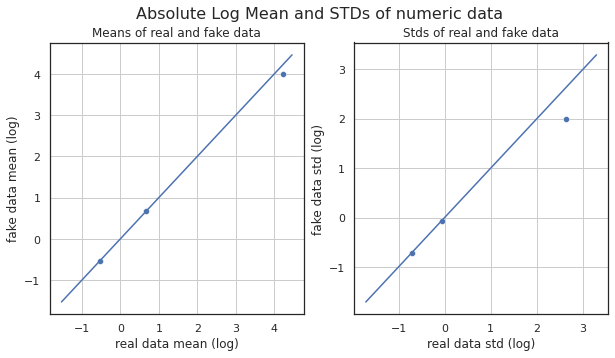

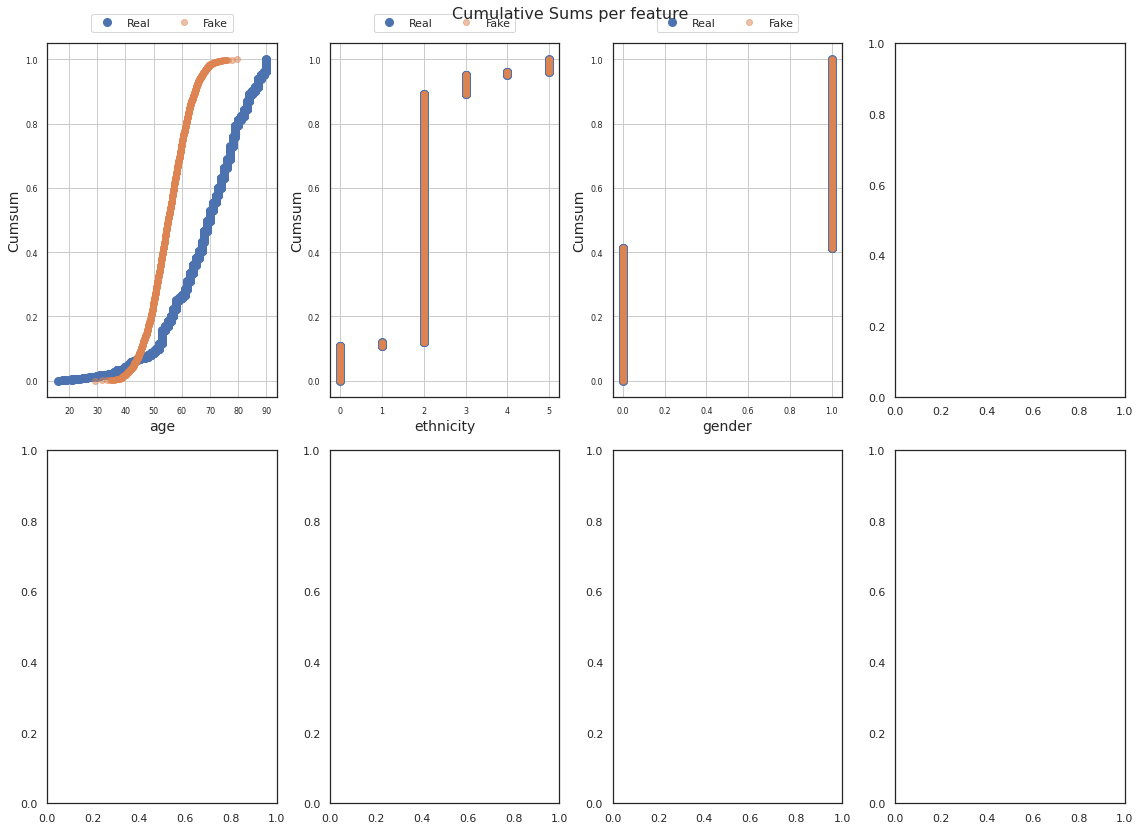

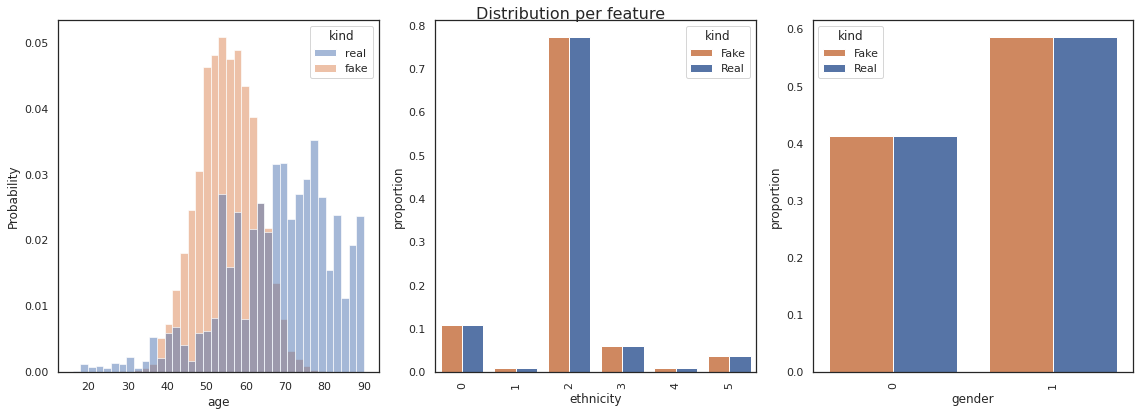

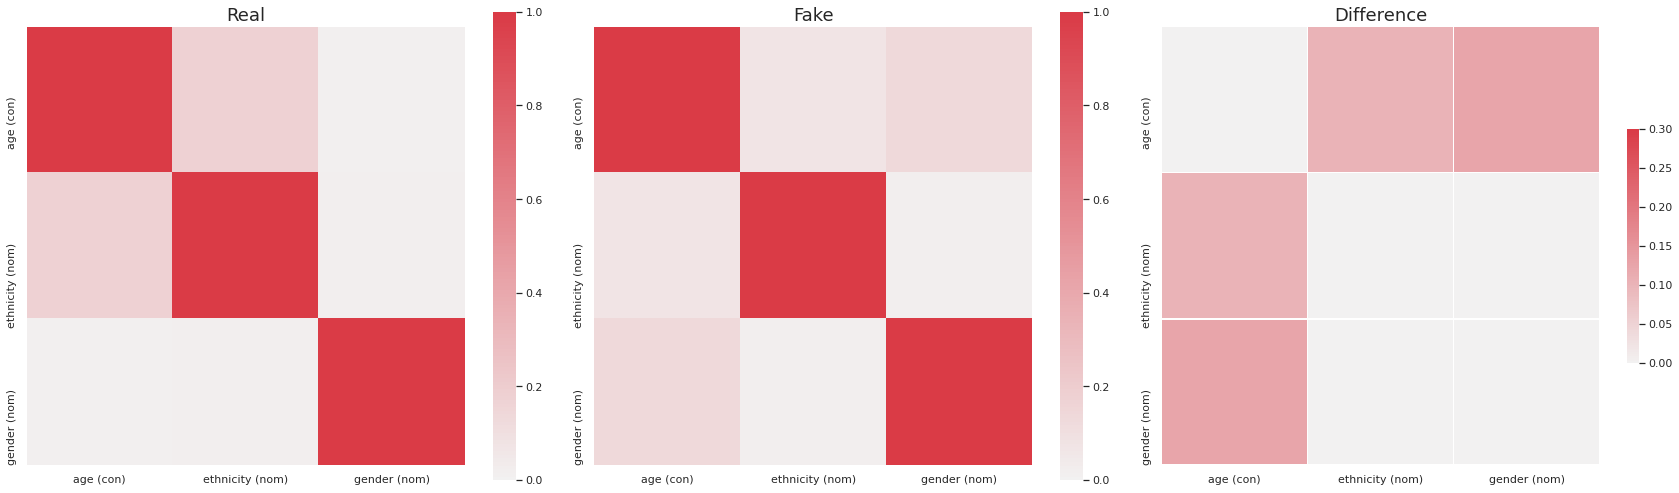

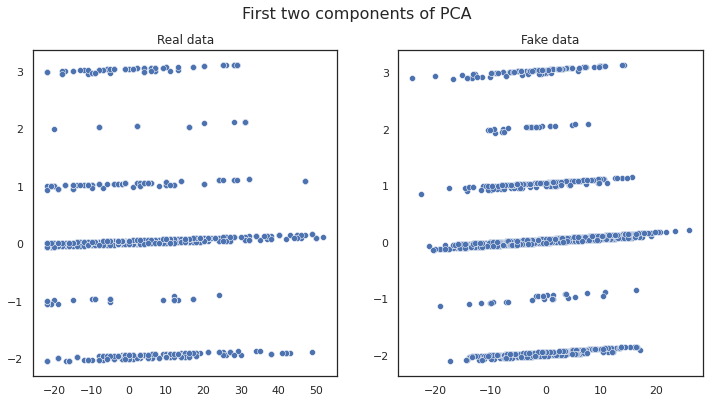

In [67]:
table_evaluator.visual_evaluation()